# Determinare il numero di persone presenti in appartamento


## Contesto e Obiettivo del modello di predizione
il modello di predizione da sviluppare andrà ad analizzare i dati output di diversi sensori presenti in una piccola stanza tra cui temperatura, luce, rumore e presenza di CO2, da questi dovrà stimare il numero di persone presenti. Le rivelazioni sono state effettuate in un periodo di 4 giorni con un'occupanza variabile tra 0 e 3 persone.

Sarà importante analizzare i dati contenuti nel dataset e derterminare la presenza o meno di feature ridondanti o non utili nella predizione.

### Fonte del Dataset
il dataset è pubblicamente accessibile al sito https://archive.ics.uci.edu al seguene link: [Room Occupancy Estimation](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation)

### Struttura del dataset
Il dataset utilizzato è il risutato di un esperimento svolto in una piccola stanza con un setup di 7 sensori che  ogni 30 secondi trasmettevano i dati rilevati tramite ricetrasmettitore al sistema centrale.

Sono stati impiegati 5 tipi di sensori: temperatura, luce, suono, CO2 e infrared digitali passivi (PIR).

Per temperatura, luce e suono sono stati impiegati 4 sensori differenti.

## Importazione delle librerie

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration
### Importazione del dataset

In [4]:
import os.path
file = "./Occupancy_Estimation.csv"
if not os.path.exists(file):
    print("Dataset assente, puoi scaricarlo dal seguente link: https://archive.ics.uci.edu")

occupancy = pd.read_csv(file)

In [5]:
occupancy.head(3)

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1


In [6]:
occupancy.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

Dalla descrizione dei dati racchiusi nel dataset sappaimo che date non sarà di alcuna utilità al modello predittivo avendo raccolto dati per soli 4 giorni, quindi verrà scartata. 

Time può essere trasformato in una variabile numerica andando a calcolare per ogni orario il numero di secondi dalle 00:00 trascorsi.

I sensori di movimento restituiscono risultati binari, quindi è più corretto trattarli come booleani.

In [46]:
from datetime import time

#traformo Time in unix
def convert_time_to_seconds(t):
    if t is None:
        return None  
    parts = t.split(':')
    if len(parts) != 3:
        return None  
    return int(parts[2]) + int(parts[1]) * 60 + int(parts[0]) * 3600

occupancy['Time'] = occupancy['Time'].apply(convert_time_to_seconds)

occupancy.drop('Date', axis=1, inplace=True)

# Converto S6_PIR e S7_PIR a booleani
occupancy['S6_PIR'] = occupancy['S6_PIR'].astype('bool')
occupancy['S7_PIR'] = occupancy['S7_PIR'].astype('bool')


occupancy['Room_Occupancy_Count'] = occupancy['Room_Occupancy_Count'].astype('int8')
occupancy.info(memory_usage="deep")
null_values = occupancy.isnull().sum().sum().astype(str)
print("Valori nulli: " + null_values)
occupancy.head(3)

AttributeError: 'int' object has no attribute 'split'

In [47]:
occupancy.describe()

,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,Room_Occupancy_Count,S1_Temp_Slope,S3_Temp_Slope
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,43233.714779,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.398559,-0.000788,-0.000702
std,26045.667721,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.893633,0.124542,0.159492
min,28.000000,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,-0.500000,-0.630000
25%,19665.000000,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,-0.060000,-0.070000
50%,43609.000000,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,66675.000000,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.060000,0.060000
max,86398.000000,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,3.000000,0.690000,1.000000


L' informazione che più salta all'occhio è che Room_Occupancy_Count è ha zero fino al quarto quartile, suggerendo uno sbilanciamento dei dati in favore di una stanza vuota rispetto che piena di un numero qualsiasi di persone. Vediamo inoltre che anche I sensori di luce seguono questo pattern, suggerendo che la stanza rimane generalmente buia, se fsse illuminata solo dalla luce artificiale sarebbe ottimo nella predizione della presenza di persone.

### Le colonne del dataset sono così definite:

Le features:
* `Date`: la data in cui è stata efefttuata la rilevazione.
* `Time`: l'ora in cui è stata effettuata la rilevazione.
* `S1_Temp`, `S2_Temp`, `S3_Temp`, `S4_Temp`: sono 4 colonne distinte che rappresentano la temperatura rilevata dai sensori di temperatura. *continue*.
* `S1_Light`, `S2_Light`, `S3_Light`, `S4_Light`: sono 4 colonne distinte che rappresentano la luce rilevata dai sensori di luce. *intere*.
* `S1_Sound`, `S2_Sound`, `S3_Sound`, `S4_Sound`: sono 4 colonne distinte che rappresentano il suono rilevato dai sensori di suono. *continue*.
* `S5_CO2`: la quantità di CO2 rilevata dal sensore di CO2. *intera*.
* `S5_CO2_Slope`: la variazione della CO2 rilevata dal sensore di CO2. *continua*.
* `S6_PIR`, `S7_PIR`: sensori di movimento. *binaria*.

L'obiettivo:
* `Occupancy`: il numero di persone presenti in stanza. *intera*.

## Prime considerazione sui dati

Time potrebbe essere un parametro rilevante, in quanto la presenza di persone in stanza potrebbe variare in base all'ora del giorno.

Non sono presenti variabili categoriche, quindi non è necessario effettuare encoding.

Sarà bene investigare l'accuratezza dei dati rivelati dai 4 sensori di luce, suono e temperatura, in quanto alcuni di essi potrebbero essere influenzati da fattori esterni e quindi falsare i dati degli altri.

In [9]:
colors_map = ["#3075EB", "#EB7530","#EB3030", "#1A921A"]

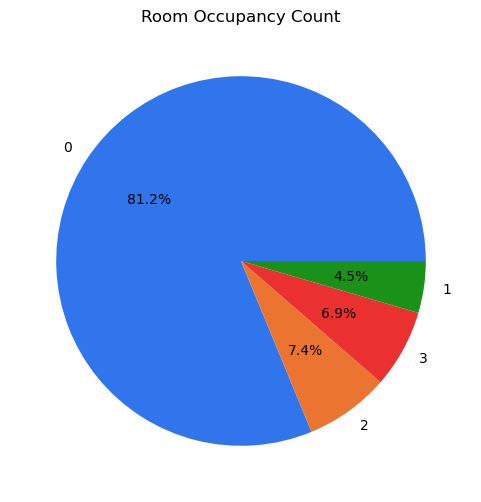

In [45]:
#grafico su Room_Occupaancy_Count a torta
plt.figure(figsize=(6,6))
occupancy['Room_Occupancy_Count'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90,colors=colors_map)
plt.title('Room Occupancy Count')
plt.ylabel('')
plt.show()

## Considerazioni sulla manipolazione delle features ed analisi dei dati rilevati dai sensori multipli di temperatura, luce e suono
I 4 sensori forniscono un'abbondanza di dati che in un dataset così ricco di record potrebbero risultare ridondanti, esploriamo alcune strategie per ridurre la complessità del dataset senza perdere informazioni utili.

Aggiungo momentaneamente tre colonne a occupancy: TempNorm, HumidityNorm e LightNorm che i valori di Temp, Humidity e Light dove è stato sommato il primo e terzo sensore e sottratto il secondo e quarto. Ciò che mi aspetto è che questi nuovi valori siano tanto più vicino allo zero quanto più i sensori rilevino valori simili. Saranno invece molto diversi dallo zero e con variazione standard tanto maggiore quanto più i sensori rilevino valori molto diversi tra loro, ad esempiò perchè piazzati lontani o in stanze diverse.

In [11]:
#nuovo dataframe pandas con le colonne che mi interessano
test = pd.DataFrame()
test["TempNorm"] = (occupancy["S1_Temp"] - occupancy["S2_Temp"]+occupancy["S3_Temp"] - occupancy["S4_Temp"])
test["LightNorm"] = (occupancy["S1_Light"] - occupancy["S2_Light"]+occupancy["S3_Light"] - occupancy["S4_Light"])
test["SoundNorm"] = (occupancy["S1_Sound"] - occupancy["S2_Sound"]+occupancy["S3_Sound"] - occupancy["S4_Sound"])

test.describe()


,TempNorm,LightNorm,SoundNorm
count,10129.000000,10129.000000,10129.000000
mean,-0.789551,20.457005,0.102390
std,0.394946,57.388758,0.460805
min,-3.950000,-89.000000,-2.930000
25%,-0.880000,0.000000,-0.010000
50%,-0.810000,0.000000,0.010000
75%,-0.560000,14.000000,0.030000
max,0.070000,307.000000,6.390000


Possiamo osservare che mentre la temperatura e il rumore rilevato dai sensori è molto simile, la luce rilevata dai sensori è molto diversa tra loro. Questo è intuitivamente ragionevole: la temperatura generalmente si distribuisce in modo uniforme in una stanza, mentre la luce può variare molto in base alla posizione dei sensori, o ad esempio per una separazione dalla sala generale, pensiamo ad un corridoio o un bagno.

Andiamo a rappresentare con un boxplot la distribuzione dei valori lungo i 4 sensori.

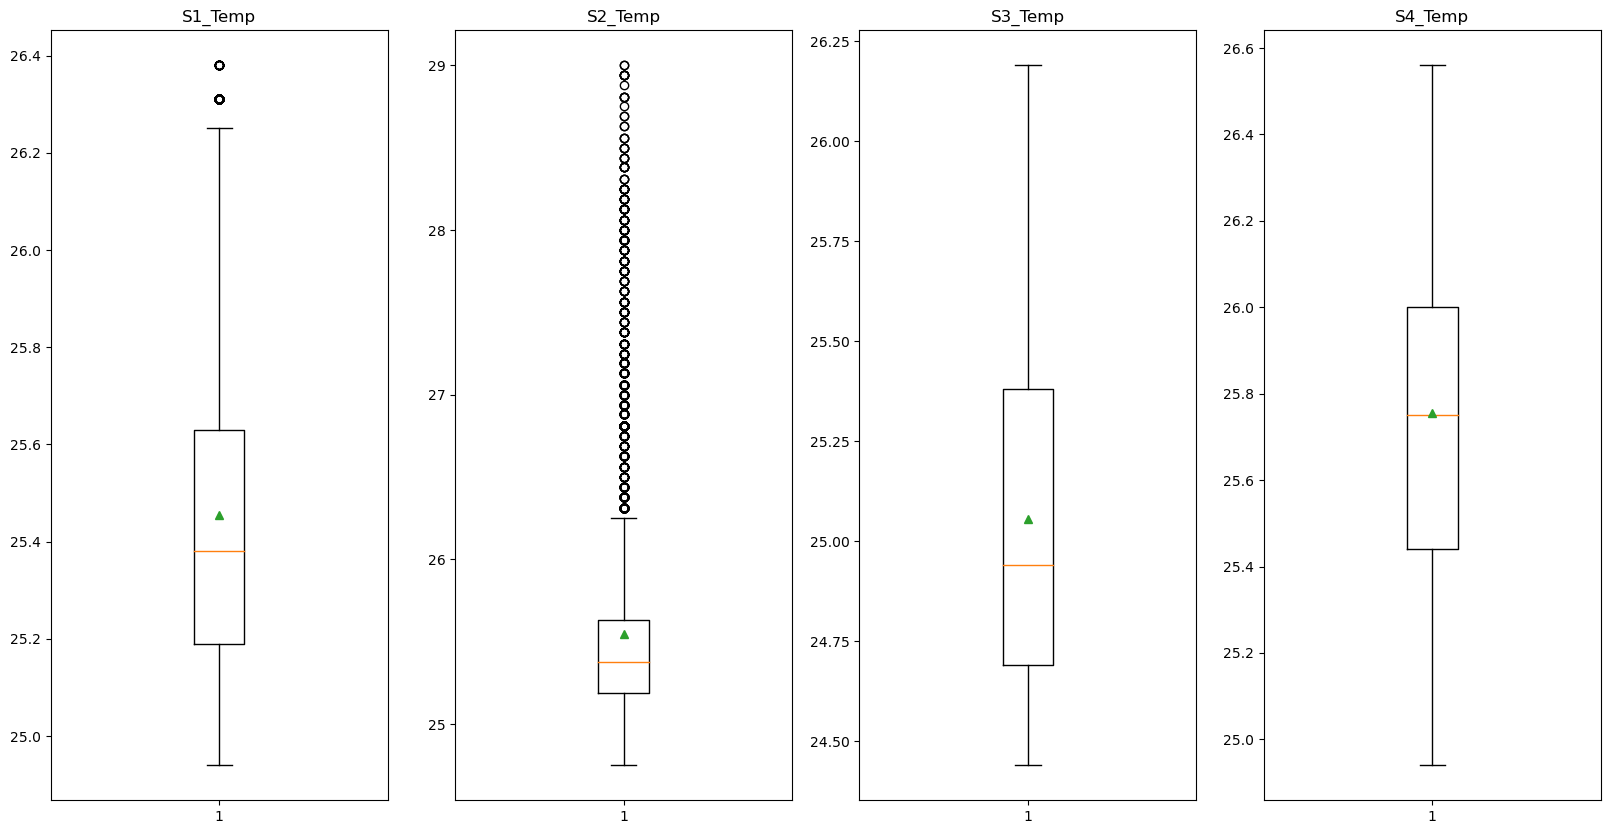

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize=(20, 10))
axes[0].boxplot(occupancy["S1_Temp"],showmeans=True)
axes[1].boxplot(occupancy["S2_Temp"],showmeans=True)
axes[2].boxplot(occupancy["S3_Temp"],showmeans=True)
axes[3].boxplot(occupancy["S4_Temp"],showmeans=True)

axes[0].set_title('S1_Temp')
axes[1].set_title('S2_Temp')
axes[2].set_title('S3_Temp')
axes[3].set_title('S4_Temp')

plt.show()

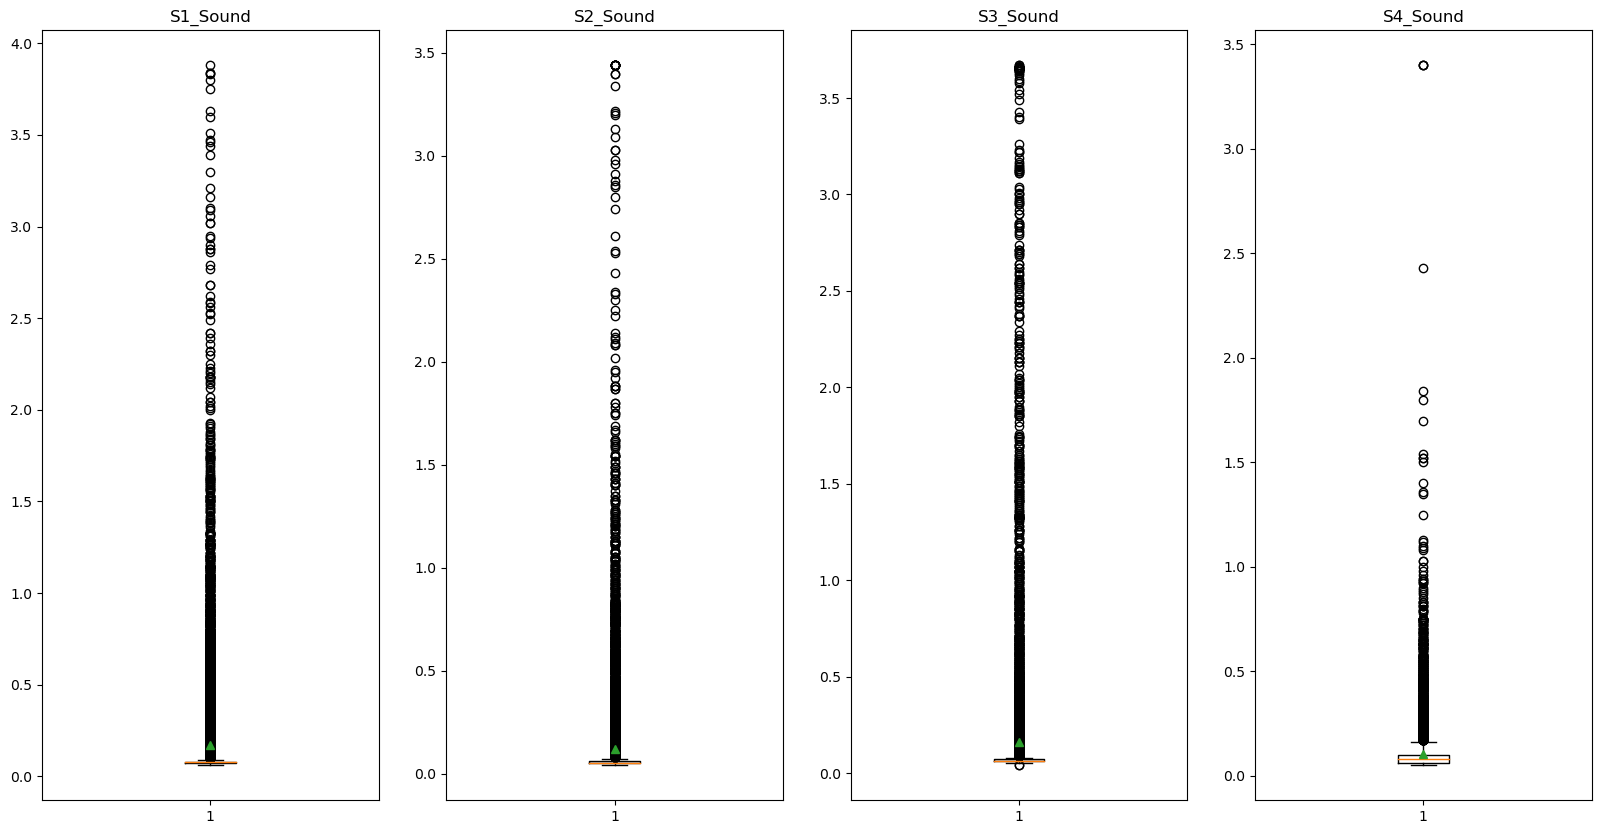

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize=(20, 10))
axes[0].boxplot(occupancy["S1_Sound"],showmeans=True)
axes[1].boxplot(occupancy["S2_Sound"],showmeans=True)
axes[2].boxplot(occupancy["S3_Sound"],showmeans=True)
axes[3].boxplot(occupancy["S4_Sound"],showmeans=True)

axes[0].set_title('S1_Sound')
axes[1].set_title('S2_Sound')
axes[2].set_title('S3_Sound')
axes[3].set_title('S4_Sound')

plt.show()

Non risulta immediatamente comprensibile questo grafico: possiamo vedere che la media è molto vicina allo 0, magli outliers sono troppi per capire se la loro distribuzione è regolare, al momento il sensore 4 appare meno descrittivo degli altri, ma non è facile determinarlo con certezza al momento, analizziamo i sensori di suono con un grafico a barre, invece.

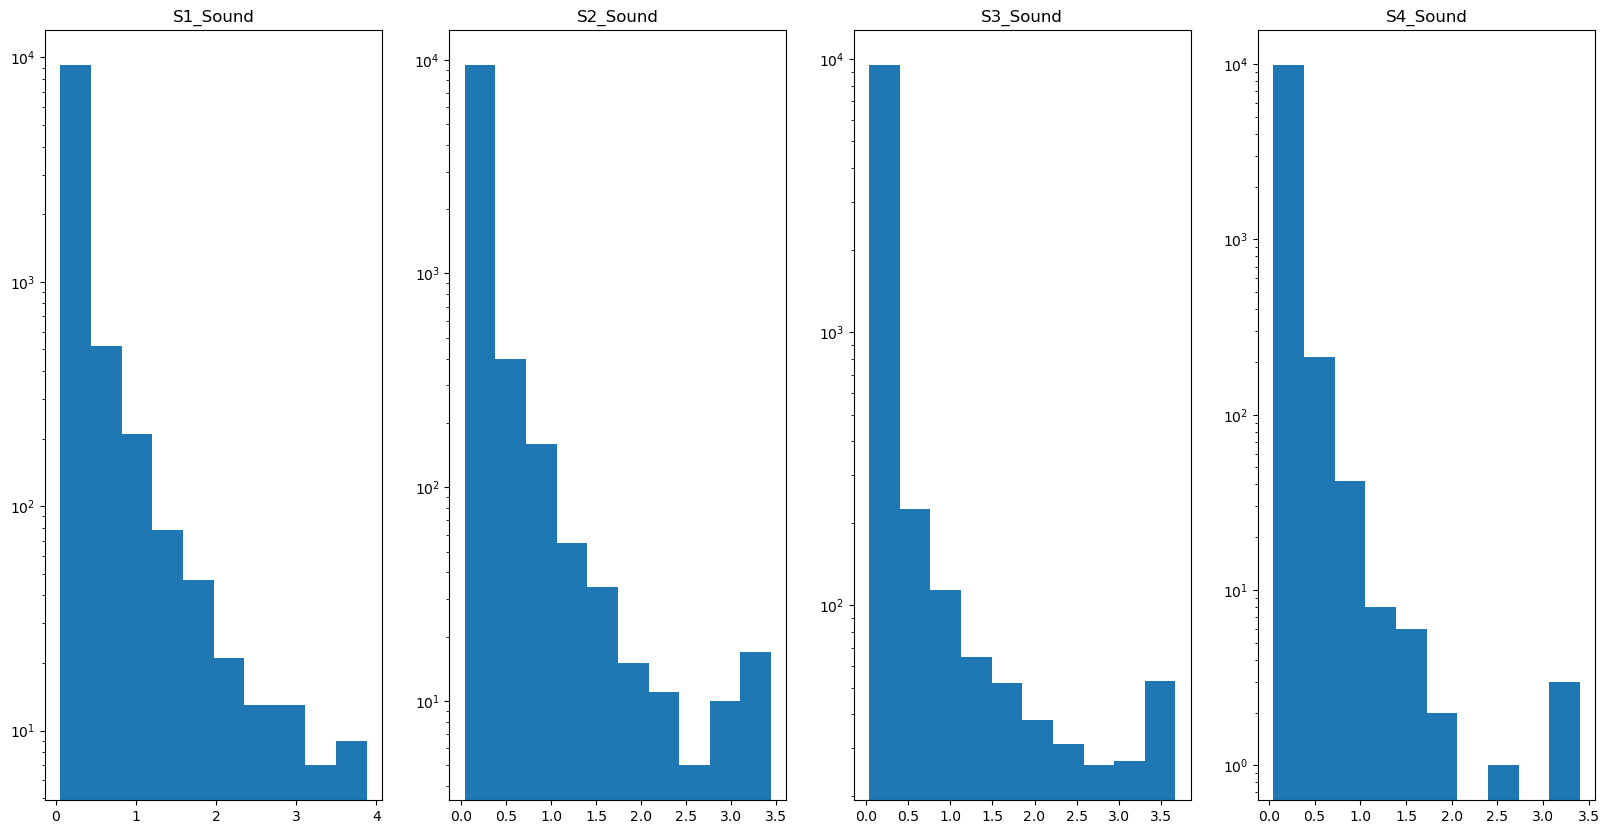

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize=(20, 10))
axes[0].hist(occupancy["S1_Sound"],bins=10,log=True)
axes[1].hist(occupancy["S2_Sound"],bins=10,log=True)
axes[2].hist(occupancy["S3_Sound"],bins=10,log=True)
axes[3].hist(occupancy["S4_Sound"],bins=10,log=True)

axes[0].set_title('S1_Sound')

axes[1].set_title('S2_Sound')
axes[2].set_title('S3_Sound')
axes[3].set_title('S4_Sound')

plt.show()

Ora è più facile vedere che la distribuzione dei valori è molto simile tra i sensori ed il quarto non presenta uan situazione molto dissimile dagli altri quanto poteva apparire nel boxplot.

Prestiamo attenzione al fatto che il grafico è in scala logaritmica lungo l'asse delle y, dunque la stragrande maggioranza dei dati si concetra intorno allo 0.

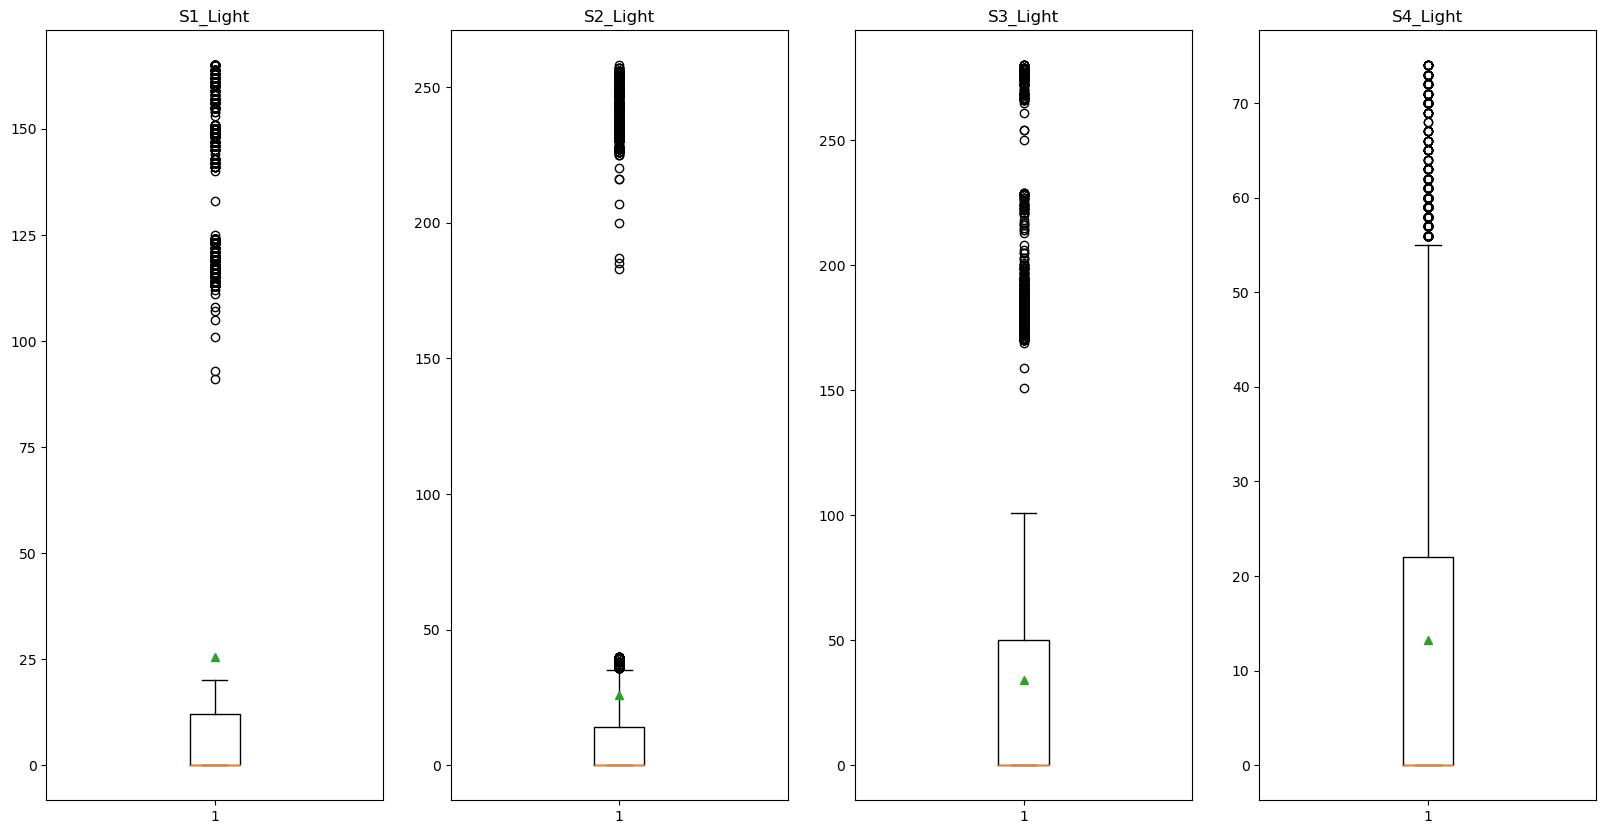

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize=(20, 10))
axes[0].boxplot(occupancy["S1_Light"],showmeans=True)
axes[1].boxplot(occupancy["S2_Light"],showmeans=True)
axes[2].boxplot(occupancy["S3_Light"],showmeans=True)
axes[3].boxplot(occupancy["S4_Light"],showmeans=True)

axes[0].set_title('S1_Light')
axes[1].set_title('S2_Light')
axes[2].set_title('S3_Light')
axes[3].set_title('S4_Light')

plt.show()

Come è ragionevole aspettarsi mentre i vari sensori di temperatura hanno pochi outliers e generalmente valori simili, i sensori di luce e di rumore hanno moltissimi outliers, riguardo ai rumori generalmente ci si aspetta uno stato di quiete interrotto da pochi e intensi momenti di rumore, riguardo alla luce gli outliers sono molto probabilmente causati dalla presenza umana, questo ci fa intuire che la luce potrebbe essere un parametro molto importante per la predizione della presenza di persone in stanza.

Vediamo che il sensore di temperatura 2 ha un range leggermente minore di dati rispetto agli altri con molti outliers, questo potrebbe indicare che il sensore è posizionato in una zona vicino a una fonte di calore o freddo, se ipotizziamo che questo sia causato da un termosifone o un piano cottura sarà ragionevole attendersi una uan descrizione della presenza umana più significativa da questo sensore.

Inoltre possiamo vedere che il sensore di luce 4 ha un range di valori molto ampio con pochi outliers indicando probabilmente una posizione suggetta alla luce diretta del sole più influenzata da fattori naturali piuttosto che umani, mentre gli altri hanno valori molto più bassi con molti outliers, indicando un luogo più buio in cui viene ogni tanto accesa la luce, dunque più significativo nel rilevare la presenza umana.

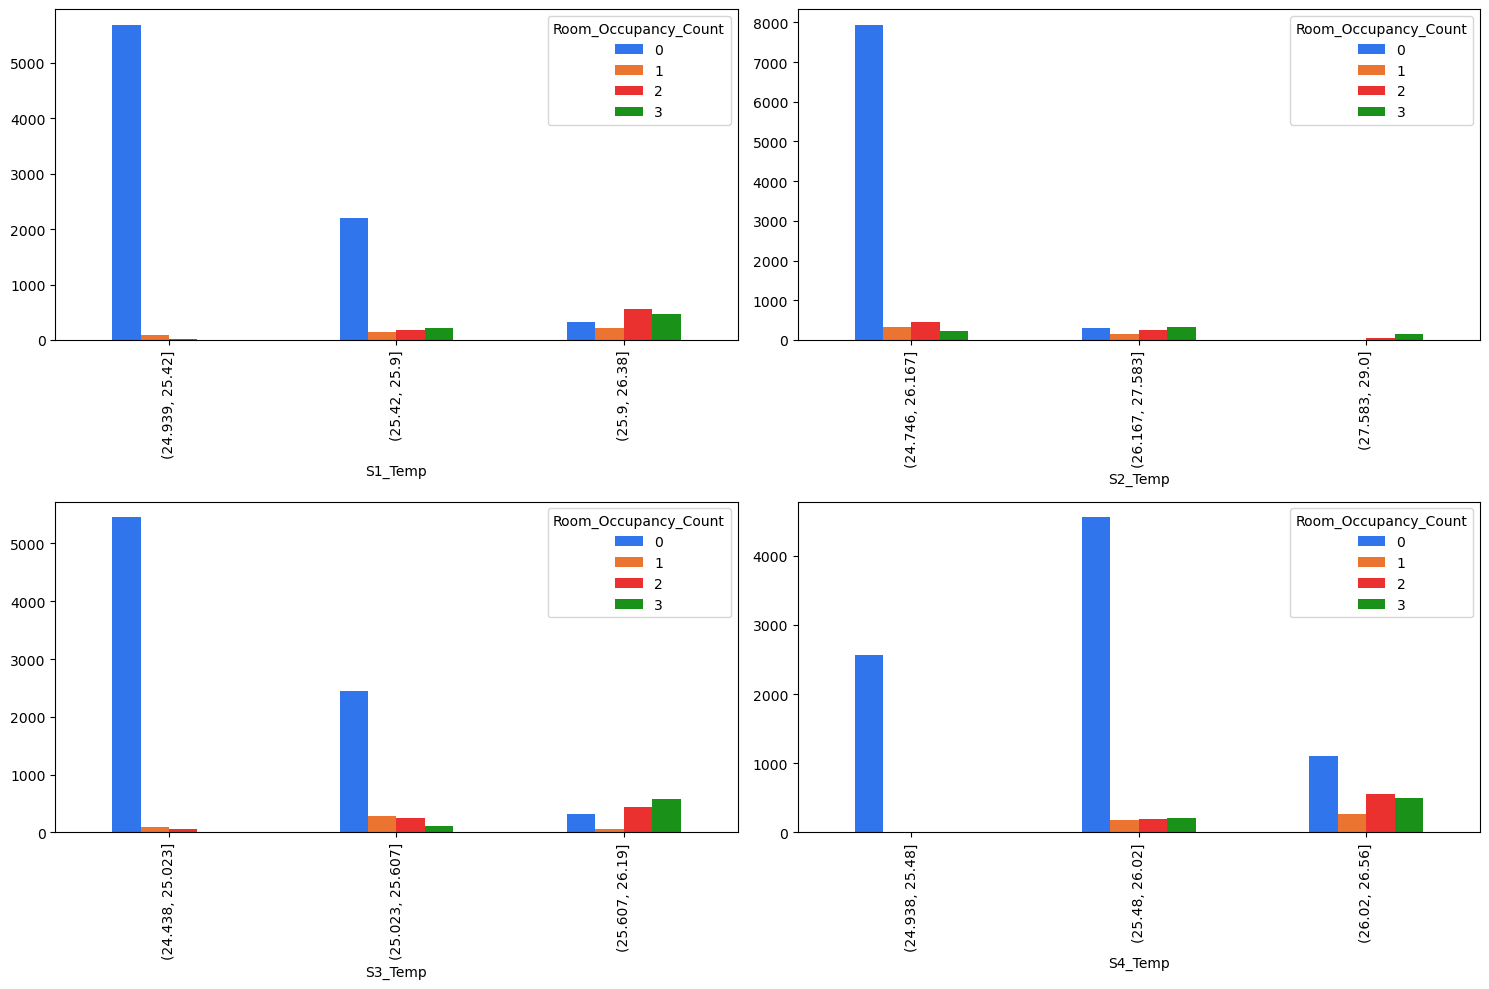

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

occupancy.groupby([pd.cut(occupancy["S1_Temp"], bins=3), "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[0, 0],color=colors_map)
occupancy.groupby([pd.cut(occupancy["S2_Temp"], bins=3), "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[0, 1],color=colors_map)
occupancy.groupby([pd.cut(occupancy["S3_Temp"], bins=3), "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[1, 0],color=colors_map)
occupancy.groupby([pd.cut(occupancy["S4_Temp"], bins=3), "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[1, 1],color=colors_map)

plt.tight_layout()
plt.show()

Come ipotizzato il sensore di temperatura 2 presenta alcuni valori particolarmente alti che corrispondono quasi univocamente all'occupazione della stanza, capiamo che questo sensore sarà molto significativo nella predizione della presenza umana. Anche il sensore 1 e soprattutto 3 evidenziano presenza umana nei valori alti, il 4 invece appare meno determinante.

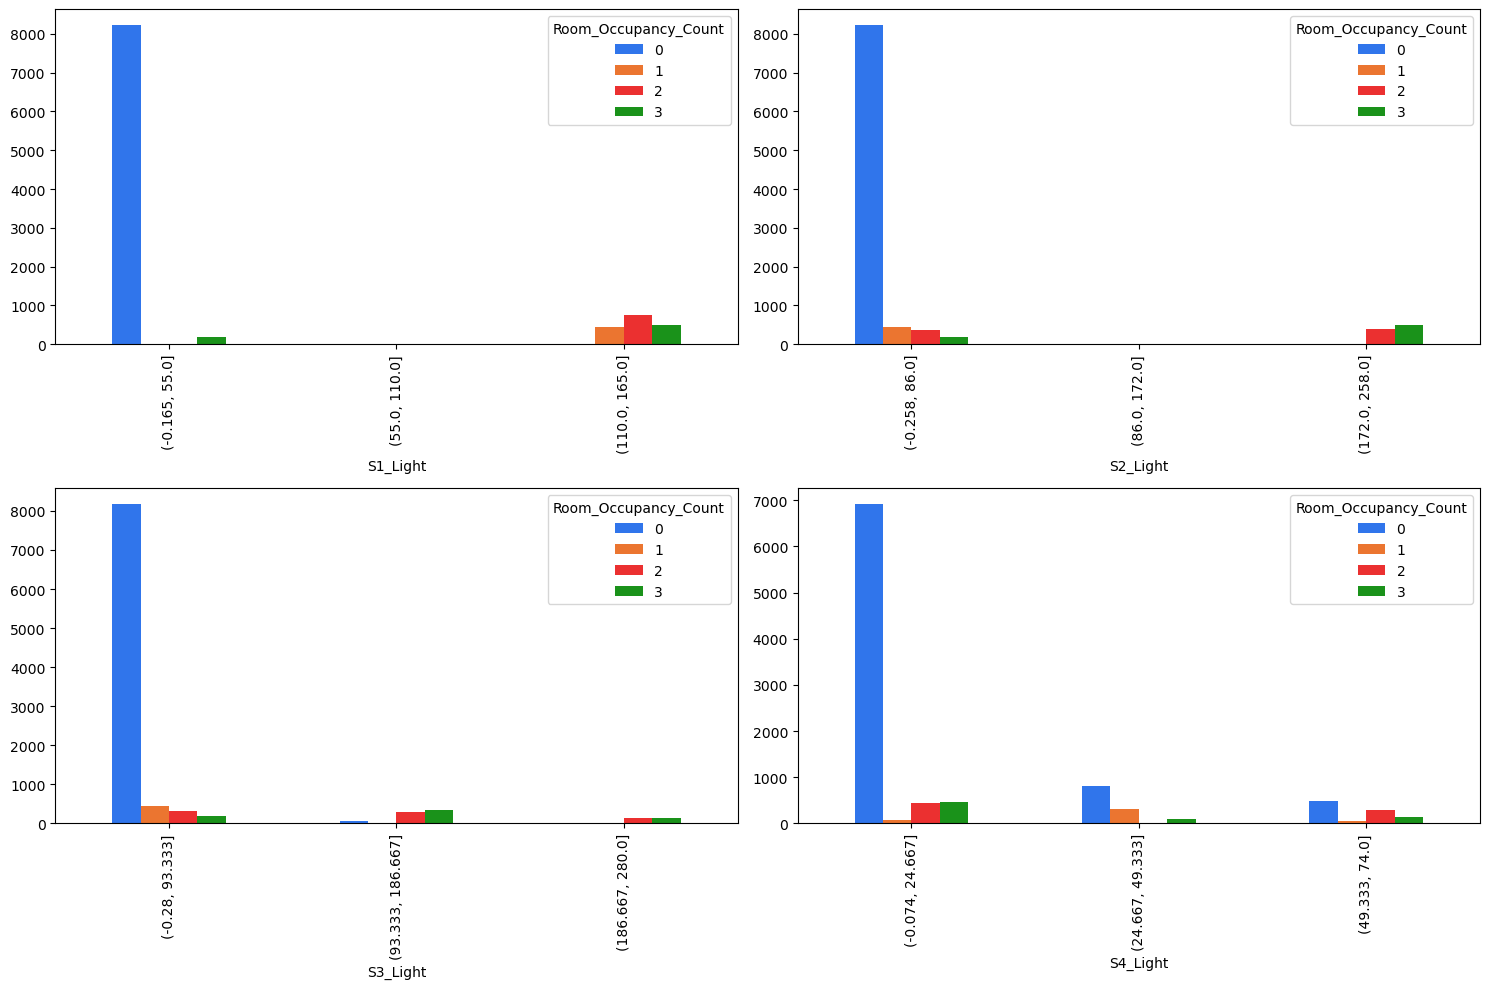

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

occupancy.groupby([pd.cut(occupancy["S1_Light"], bins=3), "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[0, 0],color=colors_map)
occupancy.groupby([pd.cut(occupancy["S2_Light"], bins=3), "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[0, 1],color=colors_map)
occupancy.groupby([pd.cut(occupancy["S3_Light"], bins=3), "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[1, 0],color=colors_map)
occupancy.groupby([pd.cut(occupancy["S4_Light"], bins=3), "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[1, 1],color=colors_map)

plt.tight_layout()
plt.show()

Come si era intuito prima mentre i primi tre sensori individuano nei picchi luminosi con una certa accuratezza la presenza di persone, il sensore 4 ha una distribuzione molto più uniforme nei propri valori, e dunque meno determinante per il riconoscimento della presenza di persone.

In [17]:
colors_map_dic = {val: color for val, color in zip([0,1,2,3], colors_map)}

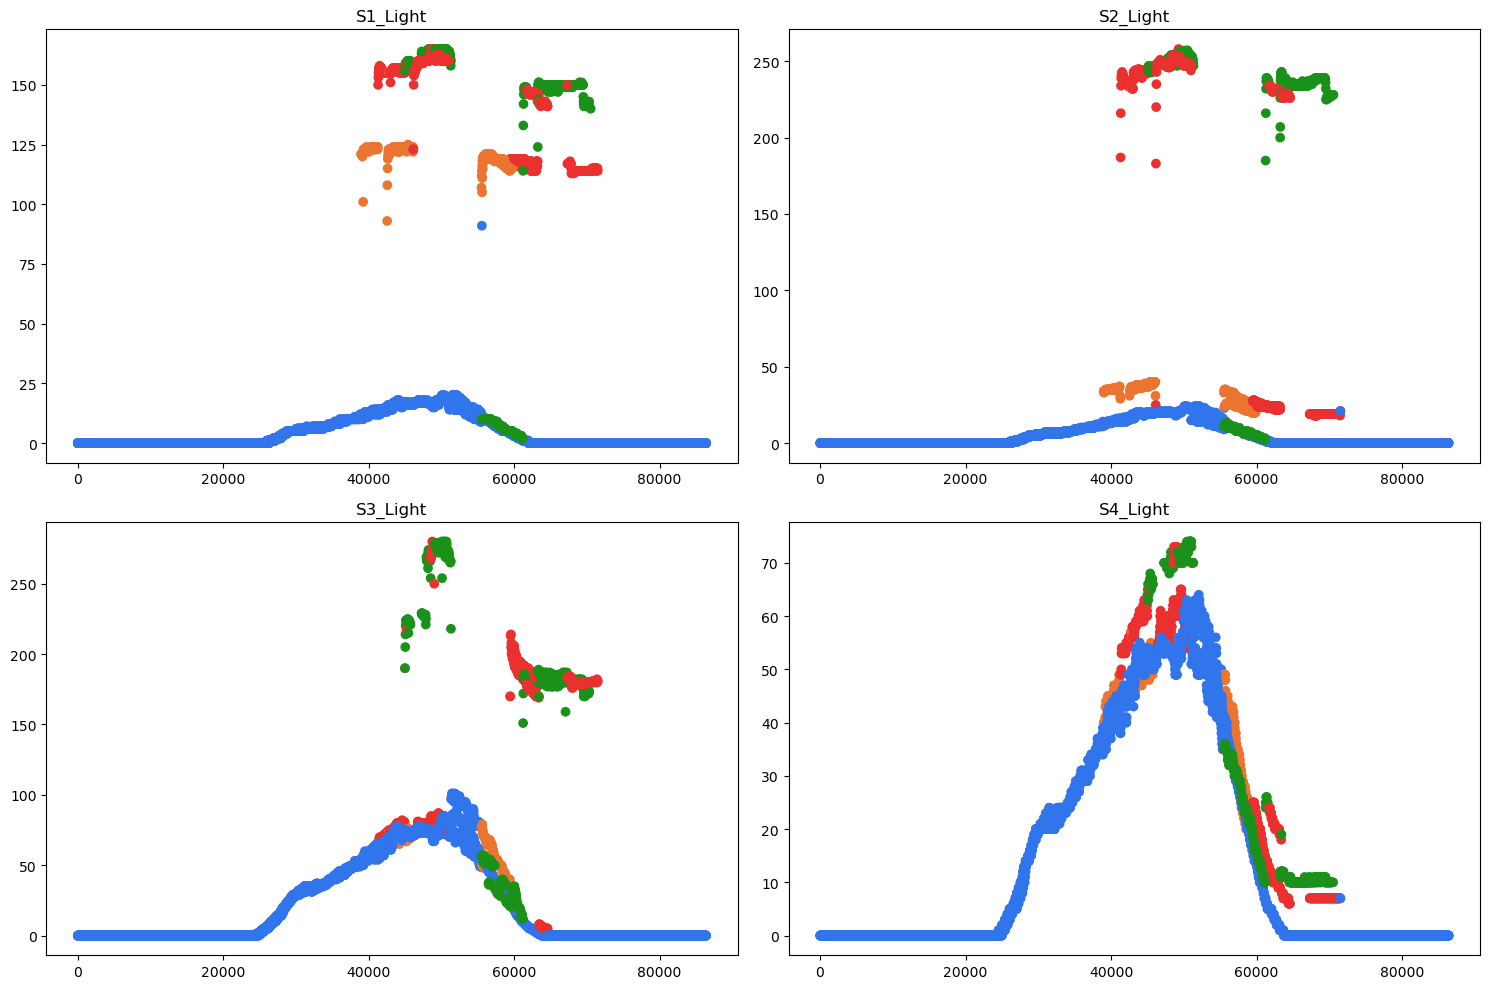

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# S1_Temp scatter plot
axs[0, 0].scatter(occupancy["Time"], occupancy["S1_Light"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0, 0].set_title('S1_Light')

# S2_Temp scatter plot
axs[0, 1].scatter(occupancy["Time"], occupancy["S2_Light"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0, 1].set_title('S2_Light')

# S3_Temp scatter plot
axs[1, 0].scatter(occupancy["Time"], occupancy["S3_Light"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1, 0].set_title('S3_Light')

# S4_Temp scatter plot
axs[1, 1].scatter(occupancy["Time"], occupancy["S4_Light"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1, 1].set_title('S4_Light')

plt.tight_layout()
plt.show()

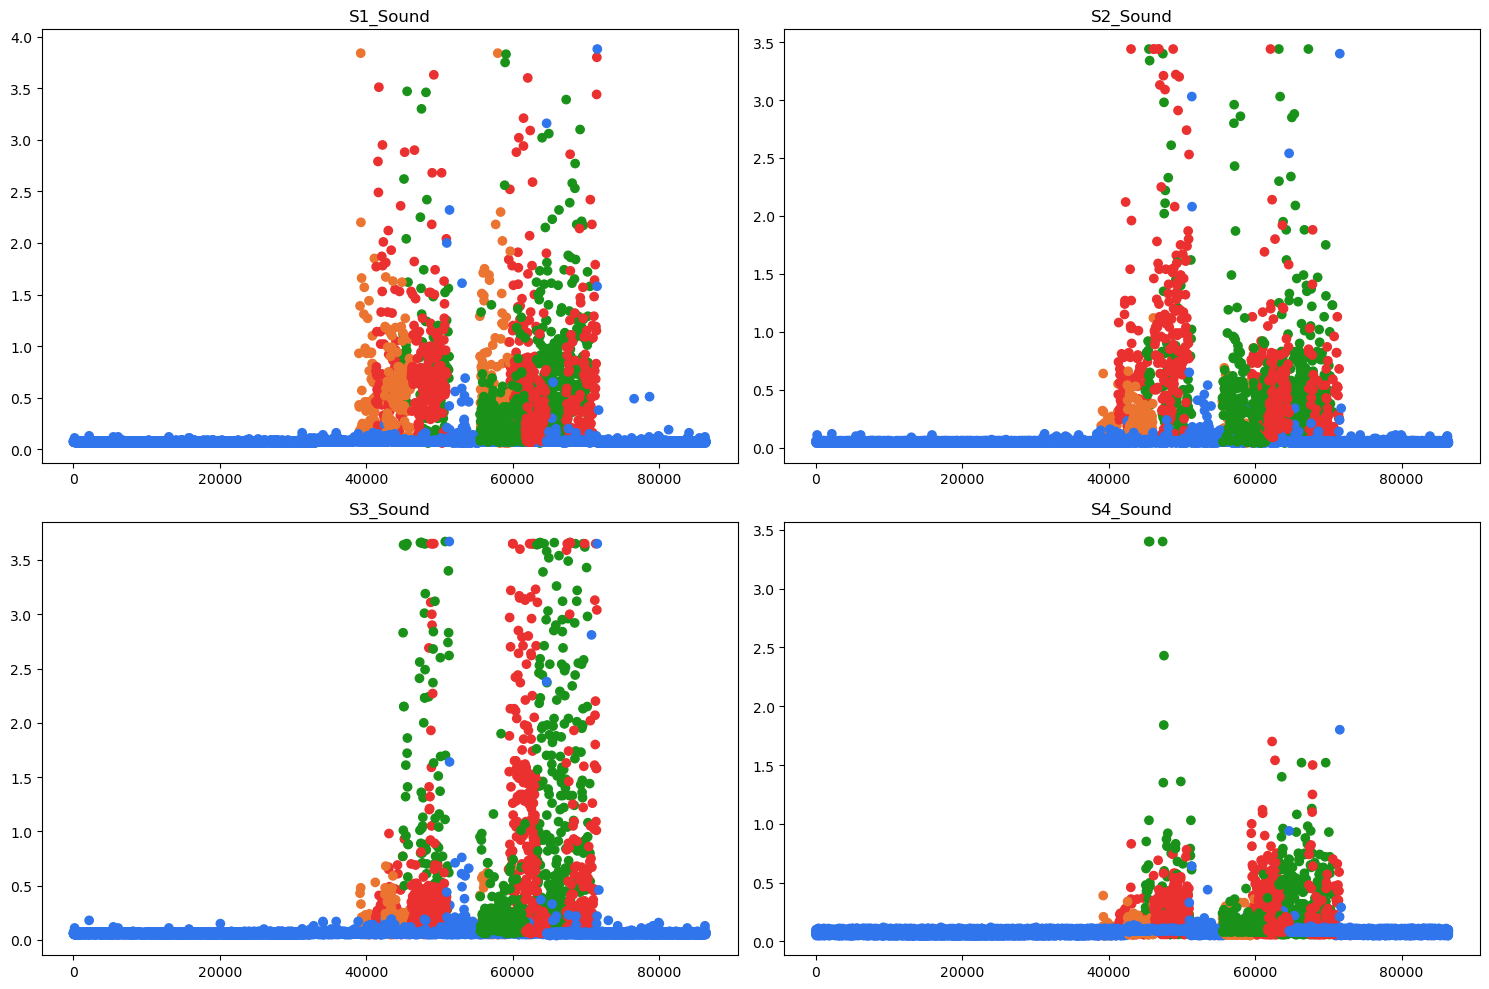

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# S1_Temp scatter plot
axs[0, 0].scatter(occupancy["Time"], occupancy["S1_Sound"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0, 0].set_title('S1_Sound')

# S2_Temp scatter plot
axs[0, 1].scatter(occupancy["Time"], occupancy["S2_Sound"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0, 1].set_title('S2_Sound')

# S3_Temp scatter plot
axs[1, 0].scatter(occupancy["Time"], occupancy["S3_Sound"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1, 0].set_title('S3_Sound')

# S4_Temp scatter plot
axs[1, 1].scatter(occupancy["Time"], occupancy["S4_Sound"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1, 1].set_title('S4_Sound')

plt.tight_layout()
plt.show()

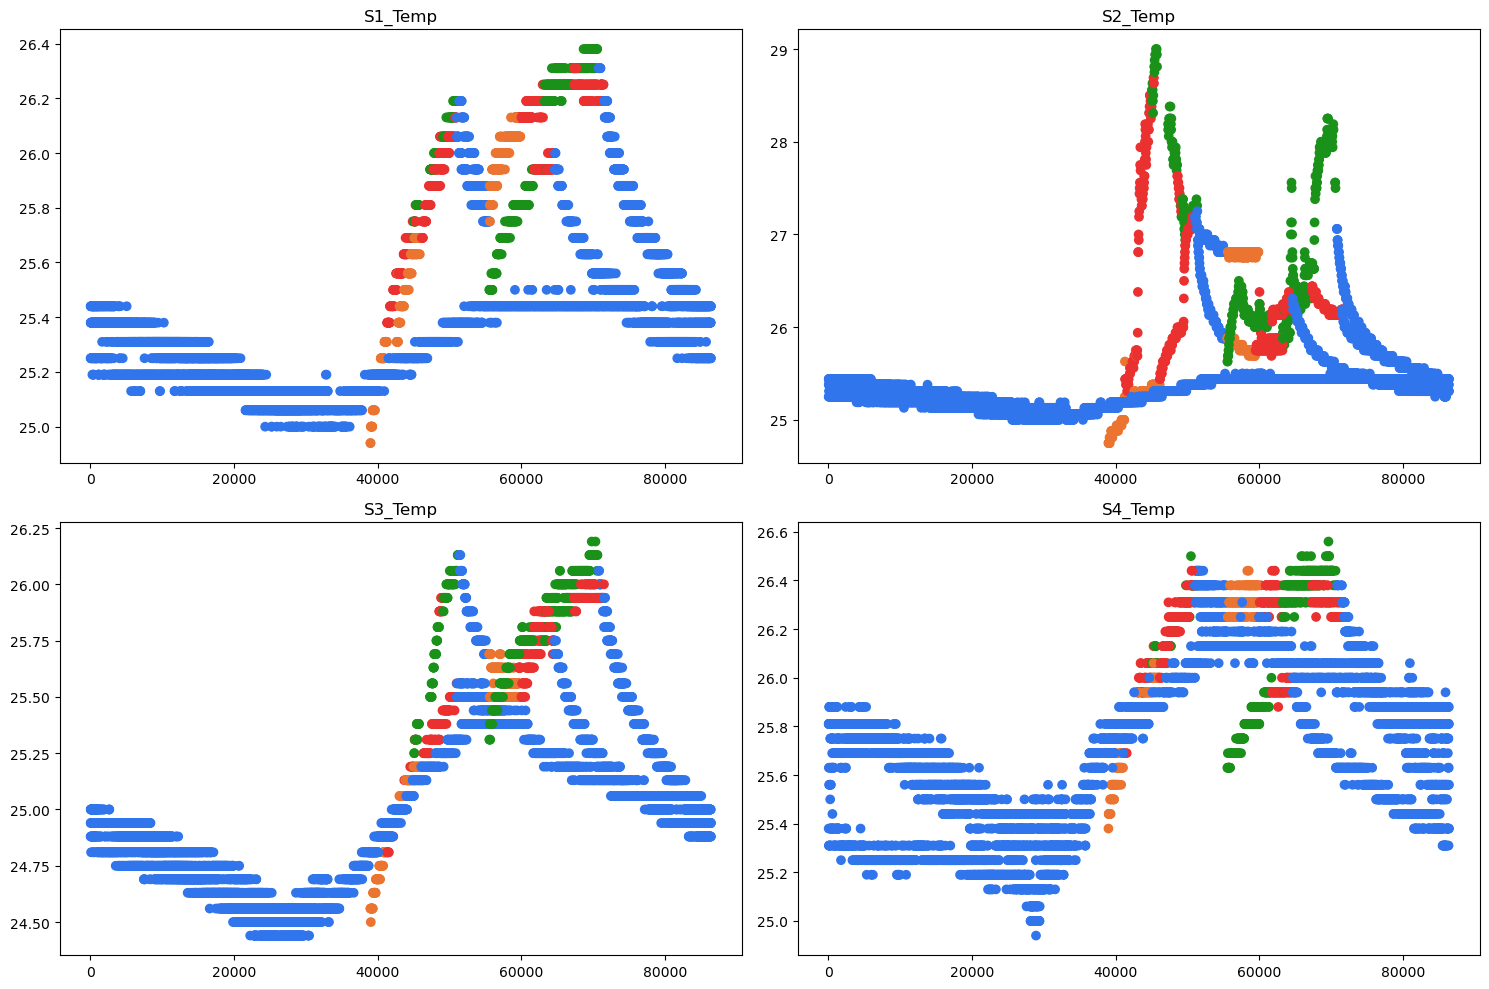

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# S1_Temp scatter plot
axs[0, 0].scatter(occupancy["Time"], occupancy["S1_Temp"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0, 0].set_title('S1_Temp')

# S2_Temp scatter plot
axs[0, 1].scatter(occupancy["Time"], occupancy["S2_Temp"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0, 1].set_title('S2_Temp')

# S3_Temp scatter plot
axs[1, 0].scatter(occupancy["Time"], occupancy["S3_Temp"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1, 0].set_title('S3_Temp')

# S4_Temp scatter plot
axs[1, 1].scatter(occupancy["Time"], occupancy["S4_Temp"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1, 1].set_title('S4_Temp')

plt.tight_layout()
plt.show()

Osserviamo che il primo e il terzo grafico sembrano predire correttamente l'entrata in stanza di una persona ma non l'uscita, la funzione di derivata prima lungo un certo range temporale potrebbe essere un buon indicatore per la presenza di persone in stanza.

Text(0.5, 1.0, 'S3_Temp_Slope')

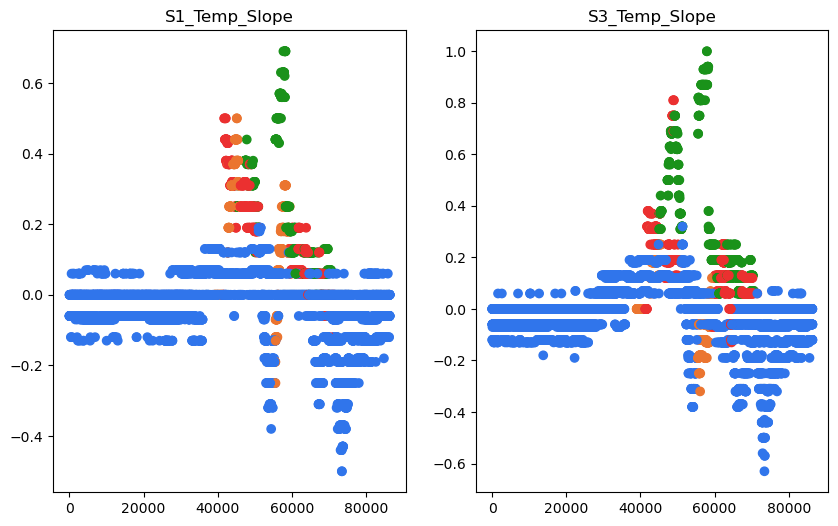

In [21]:
occupancy["S1_Temp_Slope"] = occupancy["S1_Temp"].diff(90).fillna(0)
occupancy["S3_Temp_Slope"] = occupancy["S3_Temp"].diff(90).fillna(0)


fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].scatter(occupancy["Time"], occupancy["S1_Temp_Slope"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0].set_title('S1_Temp_Slope')

# S2_Temp scatter plot
axs[1].scatter(occupancy["Time"], occupancy["S3_Temp_Slope"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1].set_title('S3_Temp_Slope')

Otteniamo conferma di diverse ipotesi fatte antecedentemente: Il sensore di temperatura più determinante per la predizione della presenza di persone è il secondo, gli altri sensori rivelano l'entrata delle persone in stanza, ma non l'uscita, la derivata di questi risulta di conseguenza un ottimo predittore della presenza.

Tutti i sensori di suono rilevano la presenza di persone in presenza di rumori forti con una certa accuratezza, particolarmente efficace è il primo che ha una buona distribuzione dei valori.

Il primo e soprattutto il secondo sensore di luce rilevano la presenza di persone molto nettamente, il terzo fatica a distinguere la presenza di più di due persone mentre il 4 come sottolienato prima è molto meno determinante.

Osserviamo inoltre che i rilevamenti della presenza di persone avvengono per tutti i sensori all'incirca le 09:00 e le 21:00 indicando che la stanza sia probabilmente un ufficio o comunque un luogo di lavoro.

## Analisi delle restanti features

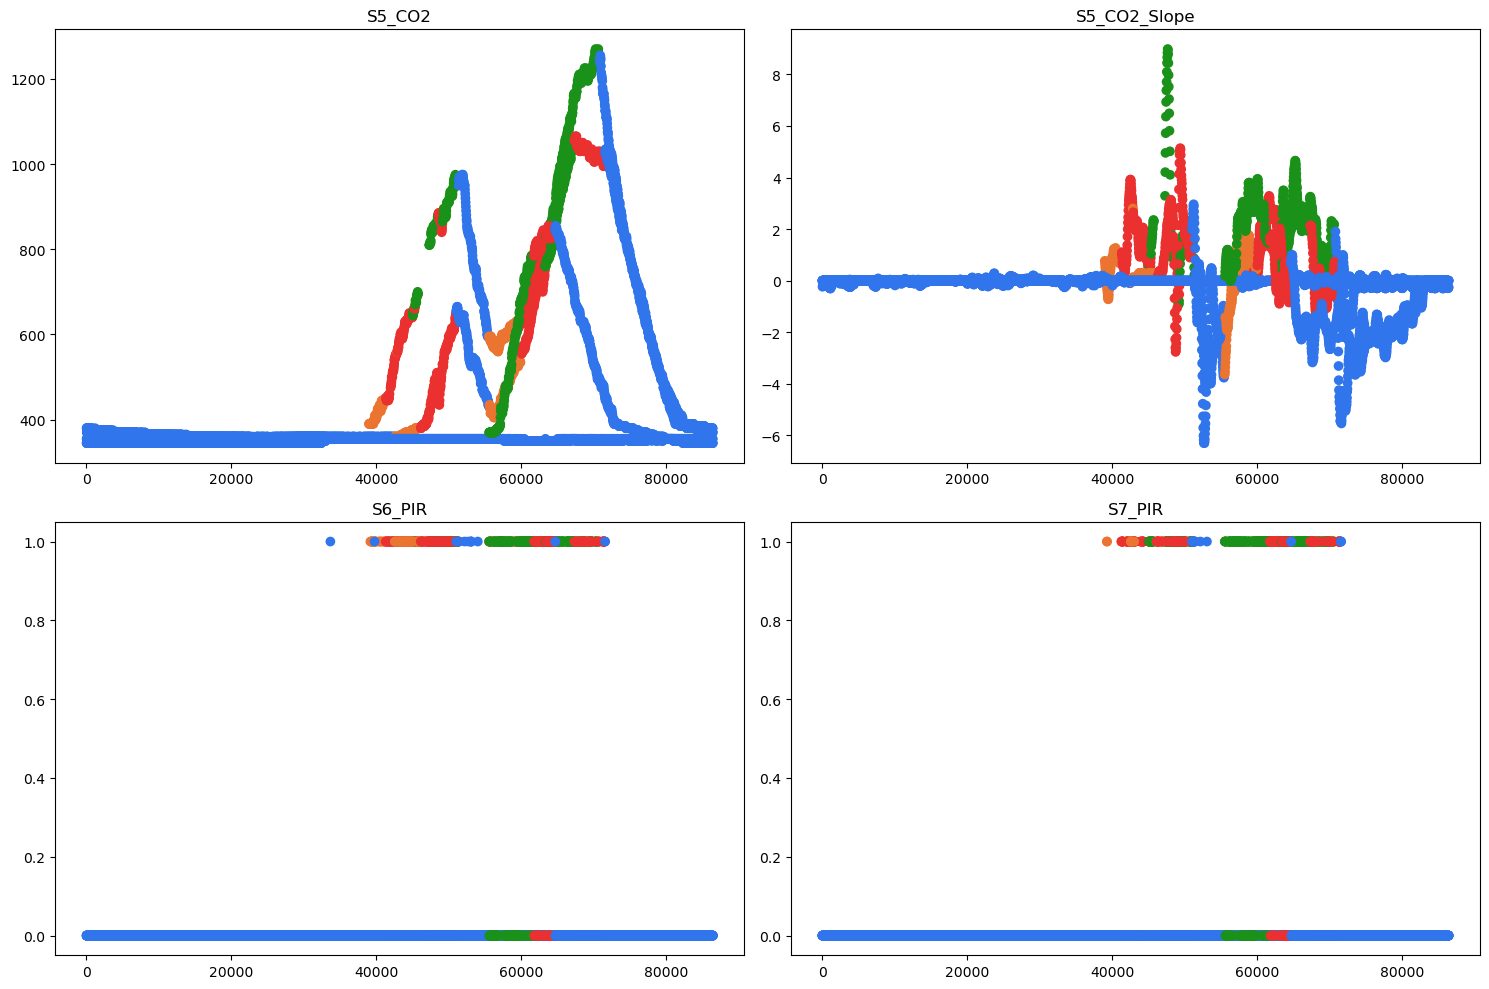

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# S5_CO2 scatter plot
axs[0, 0].scatter(occupancy["Time"], occupancy["S5_CO2"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0, 0].set_title('S5_CO2')

# S2_Temp S5_CO2_Slope plot
axs[0, 1].scatter(occupancy["Time"], occupancy["S5_CO2_Slope"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[0, 1].set_title('S5_CO2_Slope')

# S6_PIR scatter plot
axs[1, 0].scatter(occupancy["Time"], occupancy["S6_PIR"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1, 0].set_title('S6_PIR')

# S7_PIR scatter plot
axs[1, 1].scatter(occupancy["Time"], occupancy["S7_PIR"], c=occupancy["Room_Occupancy_Count"].map(colors_map_dic))
axs[1, 1].set_title('S7_PIR')

plt.tight_layout()
plt.show()

Osserviamo che la CO2 rilevata dai sensori, proprio come per la temperatura rileva egregiamente l'entrata di persone in stanza, ma non l'uscita, questo problema viene mitigato dalla derivata prima che rileva la presenza di persone in stanza in modo più uniforme.

Vediamo che i sensori di movimento rilevano la presenza di persone in stanza in modo molto accurato, utilizziamo un grafico a barre per meglio visualizzare che non vi siano nascosti molti valori pari a 0 nel grafico di fatto bidimensionale che offre lo scatterpoint su variabili binarie.

<AxesSubplot: xlabel='S7_PIR'>

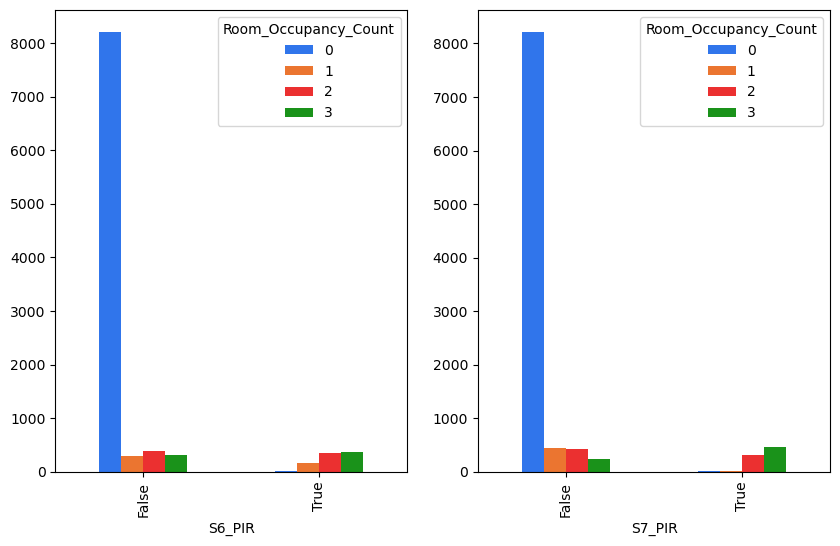

In [23]:
#barplot di S6_PIR ==0 e ==1 in base a Room_Occupancy_Count e S7_PIR ==0 e ==1 in base a Room_Occupancy_Count
fig, axs = plt.subplots(1, 2, figsize=(10,6))

occupancy.groupby(["S6_PIR", "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[0],color=colors_map)
occupancy.groupby(["S7_PIR", "Room_Occupancy_Count"], observed=False).size().unstack("Room_Occupancy_Count").plot.bar(stacked=False, ax=axs[1],color=colors_map)

    

Come è possibile vedere dal grafico il sensore di movimento ha veramente pochi falsi positivi, il primo sembra essere più efficace nell'identificare tutte le persone, mentre il secondo fatica quando ve ne è solo una, questo è probabilmente attribuibile alla posizione del sensore in un luogo particolare, ad esempio una sala riunioni o mensa.

## Scrematura dei dati
In base a quanto appurato dall'analisi esplorativa dei dati andiamo ad eliminare quelli ridondanti o superflui


In [24]:
#sostituisco le temperature rilevate da S1 e S3 con la loro derivata
occupancy_cleaned = occupancy.copy()
occupancy_cleaned.drop(columns=["S1_Temp"], inplace=True)
occupancy_cleaned.drop(columns=["S3_Temp"], inplace=True)

occupancy_cleaned.reset_index(drop=True) 
occupancy_cleaned.drop(columns=["S3_Light"], inplace=True)
occupancy_cleaned.drop(columns=["S4_Light"], inplace=True)
occupancy_cleaned.drop(columns=["S4_Temp"], inplace=True)
occupancy_cleaned.drop(columns=["S4_Sound"], inplace=True)

In [25]:
occupancy_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  10129 non-null  int64  
 1   S2_Temp               10129 non-null  float64
 2   S1_Light              10129 non-null  int64  
 3   S2_Light              10129 non-null  int64  
 4   S1_Sound              10129 non-null  float64
 5   S2_Sound              10129 non-null  float64
 6   S3_Sound              10129 non-null  float64
 7   S5_CO2                10129 non-null  int64  
 8   S5_CO2_Slope          10129 non-null  float64
 9   S6_PIR                10129 non-null  bool   
 10  S7_PIR                10129 non-null  bool   
 11  Room_Occupancy_Count  10129 non-null  int8   
 12  S1_Temp_Slope         10129 non-null  float64
 13  S3_Temp_Slope         10129 non-null  float64
dtypes: bool(2), float64(7), int64(4), int8(1)
memory usage: 900.3 KB


### Undersampling per bilanciare il dataset
Come abbiamo appurato il dataset è molto sbilanciato in favore dei record con Occupancy pari a 0, che tra l'altro offrono più rumore che informazioni utili che non possano ottenersi da un campione più ristretto, pensiamo all'assenza di suoni o la temperatura costante. Per questo motivo è ragionevole effettuare un undersampling che bilanci il dataset.

In [26]:
from sklearn.utils import resample

# Separare le classi maggioritarie e minoritarie
df_majority = occupancy_cleaned[occupancy_cleaned['Room_Occupancy_Count'] == 0]
df_minority = occupancy_cleaned[occupancy_cleaned['Room_Occupancy_Count'] != 0]

# Eseguire l'undersampling della classe maggioritaria
df_majority_undersampled = resample(df_majority,
                                    replace=False,    # non duplicare i campioni
                                    n_samples=len(df_minority),  # ridurre al numero della classe minoritaria
                                    random_state=92)  # per riproducibilità

# Combinare la classe maggioritaria undersampled con la classe minoritaria
occupancy_cleaned = pd.concat([df_majority_undersampled, df_minority])


In [55]:
occupancy_cleaned.count()["Time"]

3802

Si è comunque mantenuta una quantità accetabile di istanze anche dopo l'undersampling.

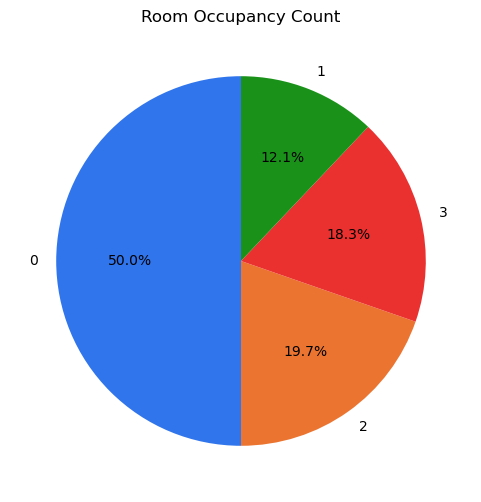

In [27]:
#grafico su Room_Occupaancy_Count a torta
plt.figure(figsize=(6,6))
occupancy_cleaned['Room_Occupancy_Count'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90,colors=colors_map)
plt.title('Room Occupancy Count')
plt.ylabel('')
plt.show()

### Divisione del dataset in training e test set


In [28]:
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [29]:
from sklearn.model_selection import train_test_split
X = occupancy_cleaned.drop(columns="Room_Occupancy_Count")
y = occupancy_cleaned["Room_Occupancy_Count"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=92)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2534, 13) (1268, 13) (2534,) (1268,)


In [30]:
def get_coefficients(model, index, model_name="model"):
    return pd.Series(model.named_steps[model_name].coef_[0], index=index)

In [31]:
model = Pipeline([
    ("model",  SGDClassifier(n_jobs=-1, random_state=92))
])
model.fit(X_train, y_train)
print("R-squared coefficient: {:.5}".format(model.score(X_val, y_val)))

R-squared coefficient: 0.71057


In [32]:
std_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  SGDClassifier())
])
std_model.fit(X_train, y_train)
print("R-squared coefficient: {:.5}".format(model.score(X_val, y_val)))

R-squared coefficient: 0.71057


In [33]:
std_model_coeff = get_coefficients(std_model, X_train.columns)
std_model_coeff

Time            -2.171050
S2_Temp          1.167583
S1_Light        -9.371327
S2_Light        -2.899623
S1_Sound        -4.041995
S2_Sound        -2.797520
S3_Sound        -2.873056
S5_CO2          -0.763286
S5_CO2_Slope    -2.012654
S6_PIR          -0.444914
S7_PIR          -4.382923
S1_Temp_Slope    0.075279
S3_Temp_Slope   -1.224215
dtype: float64

In [34]:
std_pen_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  SGDClassifier(penalty="elasticnet", alpha=0.0001))
])
std_pen_model.fit(X_train, y_train)
print("R-squared coefficient: {:.5}".format(model.score(X_val, y_val)))

R-squared coefficient: 0.71057


In [35]:
std_pen_model_coeff = get_coefficients(std_pen_model, X_train.columns)
std_pen_model_coeff

Time             -2.226859
S2_Temp           1.990066
S1_Light        -10.257773
S2_Light         -1.331295
S1_Sound         -3.793397
S2_Sound         -1.791164
S3_Sound         -2.957196
S5_CO2           -0.751988
S5_CO2_Slope     -2.295334
S6_PIR           -0.481598
S7_PIR           -4.306340
S1_Temp_Slope    -0.692274
S3_Temp_Slope    -1.390071
dtype: float64

Light si riconferma la feature più importante, seguita da S1_Sound e S5_CO2_Slope. 

Possiamo vedere che S6_PIR e S3_Sound risultano feature poco utili.

## Addestramento e validazione di vari modelli di predizione

### importo le librerie necessarie

In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [37]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=92)
models = {}

Creo una funzione che mi permetta di generalizzare la ricerca con cross validation dato un modello ed un set di parametri, inoltre stampo lo score di accuratezza ed i parametri con cui è stato ottenuto. 

In [38]:
def gridSearchWithCrossValdiation(model, grid, kf):
    grid_search = GridSearchCV(model, grid, scoring=None, cv=kf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    score = grid_search.score(X_val, y_val)

    print("Best cross validation score: {}\n".format(grid_search.best_score_))
    print("             Test set score: {}\n".format(score))
    print("                Best params: {}\n".format(grid_search.best_params_))
    print("             Best estimator: {}\n".format(grid_search.best_estimator_))
    return grid_search.best_estimator_, score

### SGDClassifier

In [39]:
per_model = Pipeline([
    ("scaler", StandardScaler()),
    ("per", SGDClassifier(n_jobs=-1, random_state=92))
])

#print(per_model.get_params())

per_grid = {
    "scaler": [None, StandardScaler()],
    "per__penalty": ["l2", "l1", "elasticnet"],
    "per__alpha": np.logspace(-3, 3, 7)
}

per_model, score = gridSearchWithCrossValdiation(per_model, per_grid, k_fold)


/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum

Best cross validation score: 0.9648782655471617

             Test set score: 0.9637223974763407

                Best params: {'per__alpha': 0.001, 'per__penalty': 'l1', 'scaler': StandardScaler()}

             Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('per',
                 SGDClassifier(alpha=0.001, n_jobs=-1, penalty='l1',
                               random_state=92))])



/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### Perceptron

In [40]:
per_model = Pipeline([
    ("scaler", StandardScaler()),
    ("per", SGDClassifier(n_jobs=-1, random_state=92))
])


per_grid = {
    "scaler": [None, StandardScaler()],
    "per__penalty": ["l2", "l1", "elasticnet"],
    "per__alpha": np.logspace(-3, 3, 7)
}

per_model, score = gridSearchWithCrossValdiation(per_model, per_grid, k_fold)
models["Perceptron"] = {"Model": per_model, "Score": score}


/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum

Best cross validation score: 0.9648782655471617

             Test set score: 0.9637223974763407

                Best params: {'per__alpha': 0.001, 'per__penalty': 'l1', 'scaler': StandardScaler()}

             Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('per',
                 SGDClassifier(alpha=0.001, n_jobs=-1, penalty='l1',
                               random_state=92))])



### K Neighbors Classifier

In [41]:
knc_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knc", KNeighborsClassifier(n_jobs=-1))
])

knc_grid = {"scaler": [None, StandardScaler()],
            'knc__n_neighbors': range(1, 10, 1),
            'knc__weights': ['uniform', 'distance']}

knc_model, score = gridSearchWithCrossValdiation(knc_model, knc_grid, k_fold)
models["K-Neighbor"] = {"Model": knc_model, "Score" : score}
models["Logistic Regression"] = {"Model" : knc_model, "Score": score}


Best cross validation score: 0.9763290221484201

             Test set score: 0.973186119873817

                Best params: {'knc__n_neighbors': 8, 'knc__weights': 'distance', 'scaler': StandardScaler()}

             Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('knc',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=8,
                                      weights='distance'))])



### Decision Tree

In [42]:
tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(random_state=42))
])

#print(tree_model.get_params())

tree_grid = {"scaler": [None, StandardScaler()],
             'tree__min_samples_split': range(2, 5, 1),
             'tree__min_samples_leaf': range(1, 5, 1), 
             'tree__max_depth': [None] + [i for i in range(2, 7)],
        }
tree_model, score = gridSearchWithCrossValdiation(tree_model, tree_grid, k_fold)
models["Decision Tree"] = {"Model": tree_model, "Score" : score}    


Best cross validation score: 0.9885570393931598

             Test set score: 0.9865930599369085

                Best params: {'scaler': None, 'tree__max_depth': None, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 3}

             Best estimator: Pipeline(steps=[('scaler', None),
                ('tree',
                 DecisionTreeClassifier(min_samples_split=3, random_state=42))])



### Random Forest


In [43]:
forest_model = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier(n_jobs=-1, random_state=42))
])

#print(forest_model.get_params())

forest_grid = {"scaler": [None, StandardScaler()],
             'forest__n_estimators': range(5, 10),
             'forest__min_samples_split': range(2, 5), 
             'forest__max_depth': [None] + [i for i in range(1, 3)],
}
forest_model, score = gridSearchWithCrossValdiation(forest_model, forest_grid, k_fold)
models["Random Forest"] = {"Model": forest_model, "Score" : score}

Best cross validation score: 0.989347553227152

             Test set score: 0.9952681388012619

                Best params: {'forest__max_depth': None, 'forest__min_samples_split': 2, 'forest__n_estimators': 8, 'scaler': StandardScaler()}

             Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('forest',
                 RandomForestClassifier(n_estimators=8, n_jobs=-1,
                                        random_state=42))])



In [44]:
for name, model in models.items():
    print(name + ":\n{}".format(model["Score"]))

Perceptron:
0.9637223974763407
K-Neighbor:
0.973186119873817
Logistic Regression:
0.973186119873817
Decision Tree:
0.9865930599369085
Random Forest:
0.9952681388012619


## Analisi del modello migliore

Possiamo vedere che il modello migliore è il Random Forest, con un'accuratezza molto vicina ad 1, segue il decision Tree che, per quanto sia meno accurato, è molto più veloce da addestrare. La scelta del modello migliore dipenderà dunque dalle esigenze del progetto, ipotizziamo diversi scenari: qualora il nostro modello dovesse essere impiegato per lo spegnimento autometico delle luci in una stanza rimasta vuota chiaramente non è uno spreco di qualche secondo o persino minuto che ci preoccupa, quanto invece l'esser sicuri di non lasciare una stanza con dei lavoratori dentro al buio.

Se invece si trattasse di un sistema di sicurezza che deve assicurarsi repentinamente della presenza o meno di persone all'itnerno di una stanza o edificio, ad esempio perchè ha rilevato un incendio, allora è molto più importante avere un modello accurato e veloce e dunque il Decision Tree offrirebbe un ottimo compromeesso.